# A toy convolutional neural network for image classification with Keras

<img src="files/dataset.png">

## Context - aim

In our previous article - Image classification with a pre-trained deep neural network -, we introduced a quick guide on how to build an image classifier, using a pre-trained neural network to perform feature extraction and plugging it into a custom classifier that is specifically trained to perform image recognition on the dataset of interest.

The present article is meant to unveil the details that are hidden inside the "black box" represented by a neural network built for image classification. We propose to build a basic convolutional neural network so as to grab the key concepts behind it, and at the same time become familiar with the Python [Keras](https://keras.io/) library for neural networks.

In our previous article, the feature extraction was performed with the deep [Inception-V3](https://arxiv.org/abs/1512.00567) trained on the [ImageNet dataset](http://www.image-net.org/) which contains millions of images, yielding a classification accuracy of 95.4% on the ([Product Image Categorization Dataset](https://www.microsoft.com/en-us/research/people/xingx/)). Unfortunately, this dataset is no longer public, that's why here we propose to use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which is composed of 60000 32x32 RGB images, distributed among 10 classes, with 6000 images per class. Three years ago, a [Kaggle competition](https://www.kaggle.com/c/cifar-10) was held, aiming to yield the best classification accuracy on this dataset. The competition winner, [Ben Graham](http://www2.warwick.ac.uk/fac/sci/statistics/staff/academic-research/graham/), reached an accuracy of 95.5% by using a deep convolutional network the architecture of which is described [here](http://blog.kaggle.com/2015/01/02/cifar-10-competition-winners-interviews-with-dr-ben-graham-phil-culliton-zygmunt-zajac/).

The architecture of the model introduced in this tutorial will be kept very basic on purpose, to allow the training and parameter tuning to be carried out on a regular computer using CPU. For this reasons, obviously our toy model won't allow us to get such an impressive performance, but let's see what accuracy we can reach!


## Image recognition and neural networks

Over the past few years, neural nets have proven to be very efficient as regards image classification. As an example, "basic" multilayer perceptrons can yield very good results in terms of classification errors on the well-known handwritten digits [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (ref : [D. C. Ciresan et al. (2010)](https://arxiv.org/pdf/1003.0358.pdf))

*To get familiar with neural networks (with a nice tutorial on the handwritten digits classification problem) : * http://neuralnetworksanddeeplearning.com/chap1.html


Object recognition using "real life" images can however prove to be tricky, and this for many reasons. A few are listed below :
- The separation between the object and its background is not necessarily obvious
- Several pictures of a same object can actually look quite different the one from the other. For example, the object's location in the image or the illumination can vary, which means the classification model needs to be invariant under certain transformations (translational symmetry for example)
- Efficient computer vision requires models that are able to exploit the 2D topology of pixels, as well as locality.


Because of their particular properties, convolutional neural networks (CNNs) allow to address the issues listed above.


### Convolutional neural networks

By construction, CNNs are well suited for image classification :
- from one convolutional layer (CL) to the next one, only a few units are connected together, which allows local treatment of subsets of pixels
- parameter sharing in one given CL contributes to translational invariance of the model
- In practice, the two constraints listed above drastically reduce the number of model parameters to be computed, and then allow to train quite complex models in reasonable time.

*Some useful references to gain knowledge of CNNs : * 
http://cs231n.github.io/convolutional-networks/


A basic CNN consists in successions of convolutional layers (CL) and pooling layers (PL). Convolutional layers allow to extract several feature maps from the input images, while pooling layers perform some subsampling (i.e. dimensionality reduction) on the feature maps. Those successions of CLs and PLs correspond to a step of feature extraction. For image classification, the output layer is a fully connected NN layer with a number of units equal to the number of classes. The output layer activation is a softmax, so that the i$^{th}$ output unit activation is consistent with the probability that the image belongs to class i.


It's also common to see in a CNN, the CLs and PLs being combined with some rectification (non-linearities) and normalization layers that can drastically improve the classification accuracy ([Jarrett et al. (2009)](http://cs.nyu.edu/~koray/publis/jarrett-iccv-09.pdf))

The following scheme, taken from [M. Peemen et al. (2011)](http://parse.ele.tue.nl/system/attachments/11/original/paperspeedsigncnn.pdf?1305713044), represents a basic architecture with two convolution+subsampling steps plugged into a classifier :

<img src="files/CNN.png">

## Building CNNs with Keras

Below are loaded some useful libraries for building, training and evaluating neural nets.
- [Keras](https://keras.io/) is a python library running either on [Tensorflow](https://www.tensorflow.org/) or [Theano](http://deeplearning.net/software/theano/). The following pieces of codes are valid for a Tensorflow implementation. [Here are some instructions to install Tensorflow](https://github.com/tensorflow/tensorflow#download-and-setup). As training neural nets can be quite computationally costly, it is recommended to install the gpu version of tensorflow (obviously, it's possible only if you have a dedicated GPU!).

- In what's next we'll use some methods that are implemented in the well-known machine learning library [scikit-learn](http://scikit-learn.org/stable/). In particular, the methods [cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) and [RandomizedSearchCV()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) will be used, respectively to apply some unit tests to the models and to perform hyperparameter tuning. For those functions to be called on Keras models, those latter will be wrapped into classes that are "compatible" with scikit-learn. [Here is some useful tutorial to build scitkit-learn wrappers for estimators](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)


In [14]:
from __future__ import print_function

import os
import re

import numpy as np
import PIL
from PIL import Image

from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Convolution2D, AveragePooling2D, MaxPooling2D, Flatten, Activation
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import cifar10

%matplotlib inline

## Loading dataset
The piece of code below allows to load the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) directly from the Keras library. To do so, the cifar10 module has to be imported from keras.datasets.

In the following, the model architecture selection and hyperparameter tuning will be performed by 3-fold cross-validation on the train set (X_train, y_train). The test set is staged for performance assessment of the model chosen in the end.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('Train set size : ', X_train.shape[0])
print('Test set size : ', X_test.shape[0])

Train set size :  50000
Test set size :  10000


## Reshaping input arrays
Below the X_train and X_test arrays are reshaped to match 2D matrices. This is because some of the scikit-learn methods that will be used later (for example RandomizedSearchCV) assume this particular shape for the input features. The X_train and X_test 2D matrices will however be reshaped to take their original format (n_examples, height, width, n_channels) before being fed into the convolutional network.

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()
n_labels = len(np.unique(y_train))

n_train = X_train.shape[0]
n_test = X_test.shape[0]
height= X_train.shape[1]
width = X_train.shape[2]
n_channels = X_train.shape[3]
print(n_train, n_test, height, width, n_channels)

X_train = X_train.reshape((n_train,height*width*n_channels))
X_test = X_test.reshape((n_test,height*width*n_channels))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

50000 10000 32 32 3
(50000, 3072) (50000,)
(10000, 3072) (10000,)


## Pipeline
The pipeline to perform model selection is inspired from the reference article [Jarrett et al. (2009)](http://cs.nyu.edu/~koray/publis/jarrett-iccv-09.pdf).

### Model architecture

#### For feature extraction

In this paper, the impact of the following model attributes on object classification accuracy is investigated :
- number of convolutional layers (CL) needed to perform feature extraction
- type of pooling (PL) used. There are typically two ways of reducing the feature dimensions : average pooling consists in keeping the mean value in a subset of the feature maps coming from the convolutional layers, whereas max pooling retains the maximum value instead.
- role of rectification layers (RL), i.e. applying some non-linearities and at the same time rectifying the values out of the convolutions so that they keep being consistent with pixels (positive values).


[Jarrett et al. (2009)](http://cs.nyu.edu/~koray/publis/jarrett-iccv-09.pdf) state that in general, the best suited architecture consists in using at least two successive convolution+pooling+rectification steps for feature extraction. In general, max pooling provides slightly better results than average pooling. As regards the rectification layers, many functions can be used but in what follows we'll stick to rectified linear units (ReLU), as those are the ones that are often the best suited for image classification.

Still, we encourage you to play by yourself with those different parameters to test if the best model architecture that you find is consistent with what [Jarrett et al. (2009)](http://cs.nyu.edu/~koray/publis/jarrett-iccv-09.pdf) claims !

#### For classification

We'll first use the most basic classifier which consists in a single fully connected output layer with 10 units (because we have 10 classes) and a softmax activation function. This corresponds to a linear classifier. Then we'll add an hidden layer between the feature extractor and the output layer, leading to more complex decision boundaries.

### Hyperparameter tuning

Some hyperparameters tuning will be performed by using [randomized search](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html). The concerned hyperparameters are :
- number of feature maps in CLs
- dimensions of feature maps in CLs
- dimensions of pooling matrices in PLs
- number of hidden units in layer between the feature extractor and the output layer.


## Define a unit_test function to extract cross-validated score for model architecture selection

In [5]:
def unit_test(classifier, nb_iter=3):
    test_size = 0.2
    random_state = 15
    cv = StratifiedShuffleSplit(y_train, nb_iter,test_size=test_size,random_state=random_state)
    clf = classifier()
    scores = cross_val_score(clf, X=X_train, y=y_train, scoring='accuracy', cv=cv)
    return scores

## Define a hyperparameter_optim function to perform randomized search 

In [6]:
def hyperparameter_optim(classifier, params, nb_iter=10, cv=3):

    clf = RandomizedSearchCV(estimator=classifier(), param_distributions=params, n_iter=nb_iter, cv=cv, scoring='accuracy')
    clf.fit(X_train, y_train)

    print("Best parameters set found:")
    print(clf.best_params_)
    print()
    print("Grid scores:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                % (mean, std * 2, params))
    print()
    
    return clf

## Playing with the model architecture

### "Basic" model with only one convolutional layer

#### Building corresponding classifier inheriting from sklearn.BaseEstimator
##### Default hyperparameters
- nb_filters = 32, filter_size = (3,3) in CL
- pool_size = (2,2) in PL
- nb_epochs = 20

##### Early stopping
- An early stopping condition based on the monitoring of the validation set accuracy is used so as to avoid overfitting and improve a bit the training time.




In [33]:
class Classifier(BaseEstimator):  

    def __init__(self, nb_filters=32, filter_size=3, pool_size=2):
        self.nb_filters = nb_filters
        self.filter_size = filter_size
        self.pool_size = pool_size
        
    def preprocess(self, X):
        X = X.reshape((X.shape[0],height,width,n_channels))
        X = (X / 255.)
        X = X.astype(np.float32)
        return X
    
    def preprocess_y(self, y):
        return np_utils.to_categorical(y)
    
    def fit(self, X, y):
        X = self.preprocess(X)
        y = self.preprocess_y(y)
        
        hyper_parameters = dict(
        nb_filters = self.nb_filters,
        filter_size = self.filter_size,
        pool_size = self.pool_size 
        )
        
        print("FIT PARAMS : ")
        print(hyper_parameters)
        
        self.model = build_model(hyper_parameters)
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')
        self.model.fit(X, y, nb_epoch=20, verbose=1, callbacks=[earlyStopping], validation_split=0.2, 
                       validation_data=None, shuffle=True)
        return self

    def predict(self, X):
        X = self.preprocess(X)
        return self.model.predict_classes(X)

    def predict_proba(self, X):
        X = self.preprocess(X)
        return self.model.predict(X)
    
    def score(self, X, y):
        print(self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None))
        return self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None)

In [34]:
def build_model(hp):
    net = Sequential()
    net.add(Convolution2D(hp['nb_filters'], hp['filter_size'], hp['filter_size'], border_mode='same', 
                          input_shape=(height,width,n_channels)))
    net.add(MaxPooling2D(pool_size=(hp['pool_size'],hp['pool_size'])))
    net.add(Flatten())
    net.add(Dense(output_dim=n_labels))
    net.add(Activation("softmax"))
    
    net.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return net

print(unit_test(Classifier,nb_iter=3))

FIT PARAMS : 
{'filter_size': 3, 'nb_filters': 32, 'pool_size': 2}
Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 17s - loss: 1.7516 - acc: 0.3930 - val_loss: 1.5888 - val_acc: 0.4462
Epoch 2/20
32000/32000 [==============================] - 18s - loss: 1.5220 - acc: 0.4780 - val_loss: 1.4962 - val_acc: 0.4794
Epoch 3/20
32000/32000 [==============================] - 19s - loss: 1.4355 - acc: 0.5101 - val_loss: 1.4381 - val_acc: 0.5032
Epoch 4/20
32000/32000 [==============================] - 19s - loss: 1.3750 - acc: 0.5319 - val_loss: 1.4049 - val_acc: 0.5084
Epoch 5/20
32000/32000 [==============================] - 19s - loss: 1.3308 - acc: 0.5454 - val_loss: 1.3772 - val_acc: 0.5218
Epoch 6/20
32000/32000 [==============================] - 19s - loss: 1.2904 - acc: 0.5600 - val_loss: 1.3328 - val_acc: 0.5353
Epoch 7/20
32000/32000 [==============================] - 19s - loss: 1.2567 - acc: 0.5744 - val_loss: 1.3121 - val_

#### Results
This first very basic model yields a classification accuracy of 55-60%, while using max pooling. You can try to replace max by average pooling. You'll notice that the latter yields poorer results (accuracy about 45-50%).

### Model with two convolutional layers

#### Building corresponding classifier inheriting from sklearn.BaseEstimator
##### Default hyperparameters
- nb_filters_1 = 32, filter_size_1 = (3,3) in 1st CL
- pool_size_1 = (2,2) in 1st PL
- nb_filters_2 = 32, filter_size_2 = (3,3) in 2nd CL
- pool_size_2 = (2,2) in 2nd PL
- nb_epochs = 10

##### Early stopping
- An early stopping condition based on the monitoring of the validation set accuracy is used so as to avoid overfitting and improve a bit the training time.



In [23]:
class Classifier(BaseEstimator):  

    def __init__(self, nb_filters_1=32, filter_size_1=3, pool_size_1=2,
                 nb_filters_2=32, filter_size_2=3, pool_size_2=2):
        self.nb_filters_1 = nb_filters_1
        self.filter_size_1 = filter_size_1
        self.pool_size_1 = pool_size_1
        self.nb_filters_2 = nb_filters_2
        self.filter_size_2 = filter_size_2
        self.pool_size_2 = pool_size_2
        
    def preprocess(self, X):
        X = X.reshape((X.shape[0],height,width,n_channels))
        X = (X / 255.)
        X = X.astype(np.float32)
        return X
    
    def preprocess_y(self, y):
        return np_utils.to_categorical(y)
    
    def fit(self, X, y):
        X = self.preprocess(X)
        y = self.preprocess_y(y)
        
        hyper_parameters = dict(
        nb_filters_1 = self.nb_filters_1,
        filter_size_1 = self.filter_size_1,
        pool_size_1 = self.pool_size_1,
        nb_filters_2 = self.nb_filters_2,
        filter_size_2 = self.filter_size_2,
        pool_size_2 = self.pool_size_2
        )
        
        print("FIT PARAMS : ")
        print(hyper_parameters)
        
        self.model = build_model(hyper_parameters)
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')
        self.model.fit(X, y, nb_epoch=20, verbose=1, callbacks=[earlyStopping], validation_split=0.2, 
                       validation_data=None, shuffle=True)
        return self

    def predict(self, X):
        print("PREDICT")
        X = self.preprocess(X)
        return self.model.predict_classes(X)

    def predict_proba(self, X):
        X = self.preprocess(X)
        return self.model.predict(X)
    
    def score(self, X, y):
        print("SCORE")
        print(self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None))
        return self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None) 
    

In [24]:
def build_model(hp):
    net = Sequential()
    net.add(Convolution2D(hp['nb_filters_1'], hp['filter_size_1'], hp['filter_size_1'], border_mode='same', 
                          input_shape=(height,width,n_channels)))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_1'],hp['pool_size_1'])))
    net.add(Convolution2D(hp['nb_filters_2'], hp['filter_size_2'], hp['filter_size_2'], border_mode='same'))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_2'],hp['pool_size_2'])))
    net.add(Flatten())
    net.add(Dense(output_dim=n_labels))
    net.add(Activation("softmax"))
    
    net.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return net

print(unit_test(Classifier,nb_iter=3))

FIT PARAMS : 
{'nb_filters_1': 32, 'nb_filters_2': 32, 'filter_size_2': 3, 'pool_size_1': 2, 'pool_size_2': 2, 'filter_size_1': 3}
Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 31s - loss: 1.7576 - acc: 0.3715 - val_loss: 1.5059 - val_acc: 0.4630
Epoch 2/20
32000/32000 [==============================] - 34s - loss: 1.4076 - acc: 0.5016 - val_loss: 1.3599 - val_acc: 0.5192
Epoch 3/20
32000/32000 [==============================] - 34s - loss: 1.3000 - acc: 0.5455 - val_loss: 1.2798 - val_acc: 0.5515
Epoch 4/20
32000/32000 [==============================] - 33s - loss: 1.2352 - acc: 0.5673 - val_loss: 1.2303 - val_acc: 0.5656
Epoch 5/20
32000/32000 [==============================] - 34s - loss: 1.1805 - acc: 0.5882 - val_loss: 1.2055 - val_acc: 0.5796
Epoch 6/20
32000/32000 [==============================] - 33s - loss: 1.1315 - acc: 0.6050 - val_loss: 1.1782 - val_acc: 0.5869
Epoch 7/20
32000/32000 [============================

#### Results
With two-steps convolutions, we go up to 66% for classification accuracy. Here the last step consists in applying a linear classifier to the features maps. Let's try to complexify the decision boundaries.

## Adding a hidden layer between CLs and output : allowing non-linear separation

In [ ]:
class Classifier(BaseEstimator):  

    def __init__(self, nb_filters_1=32, filter_size_1=3, pool_size_1=2,
                 nb_filters_2=32, filter_size_2=3, pool_size_2=2, nb_hunits=400):
        self.nb_filters_1 = nb_filters_1
        self.filter_size_1 = filter_size_1
        self.pool_size_1 = pool_size_1
        self.nb_filters_2 = nb_filters_2
        self.filter_size_2 = filter_size_2
        self.pool_size_2 = pool_size_2
        self.nb_hunits = nb_hunits
        
    def preprocess(self, X):
        X = X.reshape((X.shape[0],height,width,n_channels))
        X = (X / 255.)
        X = X.astype(np.float32)
        return X
    
    def preprocess_y(self, y):
        return np_utils.to_categorical(y)
    
    def fit(self, X, y):
        X = self.preprocess(X)
        y = self.preprocess_y(y)
        
        hyper_parameters = dict(
        nb_filters_1 = self.nb_filters_1,
        filter_size_1 = self.filter_size_1,
        pool_size_1 = self.pool_size_1,
        nb_filters_2 = self.nb_filters_2,
        filter_size_2 = self.filter_size_2,
        pool_size_2 = self.pool_size_2,
        nb_hunits = self.nb_hunits
        )
        
        print("FIT PARAMS : ")
        print(hyper_parameters)
        
        self.model = build_model(hyper_parameters)
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')
        self.model.fit(X, y, nb_epoch=20, verbose=1, callbacks=[earlyStopping], validation_split=0.2, 
                       validation_data=None, shuffle=True)
        return self

    def predict(self, X):
        print("PREDICT")
        X = self.preprocess(X)
        return self.model.predict_classes(X)

    def predict_proba(self, X):
        X = self.preprocess(X)
        return self.model.predict(X)
    
    def score(self, X, y):
        print("SCORE")
        print(self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None))
        return self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None) 
    

In [26]:
def build_model(hp):
    net = Sequential()
    net.add(Convolution2D(hp['nb_filters_1'], hp['filter_size_1'], hp['filter_size_1'], border_mode='same', 
                          input_shape=(height,width,n_channels)))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_1'],hp['pool_size_1'])))
    net.add(Convolution2D(hp['nb_filters_2'], hp['filter_size_2'], hp['filter_size_2'], border_mode='same'))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_2'],hp['pool_size_2'])))
    net.add(Flatten())
    net.add(Dense(output_dim=hp['nb_hunits']))
    net.add(Activation("relu"))
    net.add(Dense(output_dim=n_labels))
    net.add(Activation("softmax"))
    
    net.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return net

print(unit_test(Classifier,nb_iter=3))

FIT PARAMS : 
{'nb_filters_1': 32, 'nb_filters_2': 32, 'nb_hunits': 400, 'filter_size_2': 3, 'pool_size_1': 2, 'pool_size_2': 2, 'filter_size_1': 3}
Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 42s - loss: 1.6479 - acc: 0.4016 - val_loss: 1.4339 - val_acc: 0.4794
Epoch 2/20
32000/32000 [==============================] - 44s - loss: 1.2421 - acc: 0.5578 - val_loss: 1.2168 - val_acc: 0.5701
Epoch 3/20
32000/32000 [==============================] - 44s - loss: 1.0869 - acc: 0.6187 - val_loss: 1.0674 - val_acc: 0.6270
Epoch 4/20
32000/32000 [==============================] - 43s - loss: 0.9757 - acc: 0.6600 - val_loss: 1.0353 - val_acc: 0.6358
Epoch 5/20
32000/32000 [==============================] - 43s - loss: 0.8879 - acc: 0.6921 - val_loss: 0.9591 - val_acc: 0.6683
Epoch 6/20
32000/32000 [==============================] - 44s - loss: 0.8054 - acc: 0.7210 - val_loss: 0.9536 - val_acc: 0.6684
Epoch 7/20
32000/32000 [==========

#### Results
The accuracy is a bit improved (from 66% to 67%) by adding the fully connected hidden layer. Here we have arbitrarily fixed the number of hidden units to 400. 

### Hyperparameter optimization
In the following cell, we'll use randomized search to tune some hyperparameters :
- number of hidden units in the classifier
- number and size of the convolution filters
- size of pooling matrices

This is quite time consuming (about 10 hours on a laptop with CPU), that's why we advise you not to run directly this cell, but rather copy its content into a .py script that will be launch independantly.

In [ ]:
def build_model(hp):
    net = Sequential()
    net.add(Convolution2D(hp['nb_filters_1'], hp['filter_size_1'], hp['filter_size_1'], border_mode='same', 
                          input_shape=(height,width,n_channels)))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_1'],hp['pool_size_1'])))
    net.add(Convolution2D(hp['nb_filters_2'], hp['filter_size_2'], hp['filter_size_2'], border_mode='same'))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_2'],hp['pool_size_2'])))
    net.add(Flatten())
    net.add(Dense(output_dim=hp['nb_hunits']))
    net.add(Activation("relu"))
    net.add(Dense(output_dim=n_labels))
    net.add(Activation("softmax"))
    
    net.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return net

params = {
    'nb_filters_1': [16,32,64],
    'filter_size_1': [3],
    'pool_size_1': [2],
    'nb_filters_2': [16,32,64],
    'filter_size_2': [3,6,9],
    'pool_size_2': [2,4],
    'nb_hunits': sp_randint(50,1000)
}
clf = hyperparameter_optim(Classifier,params, nb_iter=10)

print("Detailed classification report:")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

FIT PARAMS : 
{'nb_filters_1': 64, 'nb_filters_2': 64, 'nb_hunits': 54, 'filter_size_2': 3, 'pool_size_1': 2, 'pool_size_2': 2, 'filter_size_1': 3}
Train on 26666 samples, validate on 6667 samples
Epoch 1/20
26666/26666 [==============================] - 69s - loss: 1.7976 - acc: 0.3452 - val_loss: 1.6459 - val_acc: 0.4120
Epoch 2/20
26666/26666 [==============================] - 71s - loss: 1.3846 - acc: 0.5056 - val_loss: 1.4104 - val_acc: 0.4939
Epoch 3/20
26666/26666 [==============================] - 71s - loss: 1.2308 - acc: 0.5638 - val_loss: 1.2499 - val_acc: 0.5596
Epoch 4/20
26666/26666 [==============================] - 70s - loss: 1.1314 - acc: 0.5997 - val_loss: 1.3136 - val_acc: 0.5439
Epoch 5/20
26666/26666 [==============================] - 74s - loss: 1.0491 - acc: 0.6299 - val_loss: 1.2617 - val_acc: 0.5626
PREDICT
16667/16667 [==============================] - 14s    
PREDICT
33333/33333 [==============================] - 28s    
FIT PARAMS : 
{'nb_filters_1': 64, 'n

#### Optimal set of hyperparameters

From a randomized search performed with 15 iterations, the best set of hyperparameters that were found is :
- nb_filters_1 = 32
- filter_size_1 = 3
- pool_size_1 = 2
- nb_filters_2 = 32
- filter_size_2 = 9
- pool_size_2 = 4
- nb_hunits = 750

Finally, we'll train a model with this architecture on the whole training set and evaluate the classification accuracy on the test set (that has never been used before).

### Training of optimized model and performance assessment on the test set

In [7]:
class Classifier(BaseEstimator):  

    def __init__(self, nb_filters_1=32, filter_size_1=3, pool_size_1=2,
                 nb_filters_2=32, filter_size_2=9, pool_size_2=4, nb_hunits=750):
        self.nb_filters_1 = nb_filters_1
        self.filter_size_1 = filter_size_1
        self.pool_size_1 = pool_size_1
        self.nb_filters_2 = nb_filters_2
        self.filter_size_2 = filter_size_2
        self.pool_size_2 = pool_size_2
        self.nb_hunits = nb_hunits
        
    def preprocess(self, X):
        X = X.reshape((X.shape[0],height,width,n_channels))
        X = (X / 255.)
        X = X.astype(np.float32)
        return X
    
    def preprocess_y(self, y):
        return np_utils.to_categorical(y)
    
    def fit(self, X, y):
        X = self.preprocess(X)
        y = self.preprocess_y(y)
        
        hyper_parameters = dict(
        nb_filters_1 = self.nb_filters_1,
        filter_size_1 = self.filter_size_1,
        pool_size_1 = self.pool_size_1,
        nb_filters_2 = self.nb_filters_2,
        filter_size_2 = self.filter_size_2,
        pool_size_2 = self.pool_size_2,
        nb_hunits = self.nb_hunits
        )
        
        print("FIT PARAMS : ")
        print(hyper_parameters)
        
        self.model = build_model(hyper_parameters)
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')
        self.model.fit(X, y, nb_epoch=20, verbose=1, callbacks=[earlyStopping], validation_split=0.2, 
                       validation_data=None, shuffle=True)
        return self

    def predict(self, X):
        print("PREDICT")
        X = self.preprocess(X)
        return self.model.predict_classes(X)

    def predict_proba(self, X):
        X = self.preprocess(X)
        return self.model.predict(X)
    
    def score(self, X, y):
        print("SCORE")
        print(self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None))
        return self.model.evaluate(self, X, y, batch_size=32, verbose=1, sample_weight=None) 


def build_model(hp):
    net = Sequential()
    net.add(Convolution2D(hp['nb_filters_1'], hp['filter_size_1'], hp['filter_size_1'], border_mode='same', 
                          input_shape=(height,width,n_channels)))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_1'],hp['pool_size_1'])))
    net.add(Convolution2D(hp['nb_filters_2'], hp['filter_size_2'], hp['filter_size_2'], border_mode='same'))
    net.add(Activation("relu"))
    net.add(MaxPooling2D(pool_size=(hp['pool_size_2'],hp['pool_size_2'])))
    net.add(Flatten())
    net.add(Dense(output_dim=hp['nb_hunits']))
    net.add(Activation("relu"))
    net.add(Dense(output_dim=n_labels))
    net.add(Activation("softmax"))
    
    net.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return net


clf = Classifier()
clf.fit(X_train,y_train)

print("Detailed classification report:")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

FIT PARAMS : 
{'nb_filters_1': 32, 'nb_filters_2': 32, 'nb_hunits': 750, 'filter_size_2': 9, 'pool_size_1': 2, 'pool_size_2': 4, 'filter_size_1': 3}
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 148s - loss: 1.5336 - acc: 0.4420 - val_loss: 1.2261 - val_acc: 0.5652
Epoch 2/20
40000/40000 [==============================] - 146s - loss: 1.1258 - acc: 0.6029 - val_loss: 1.0745 - val_acc: 0.6251
Epoch 3/20
40000/40000 [==============================] - 146s - loss: 0.9806 - acc: 0.6548 - val_loss: 0.9774 - val_acc: 0.6585
Epoch 4/20
40000/40000 [==============================] - 147s - loss: 0.8857 - acc: 0.6892 - val_loss: 0.9115 - val_acc: 0.6853
Epoch 5/20
40000/40000 [==============================] - 148s - loss: 0.8076 - acc: 0.7193 - val_loss: 0.9002 - val_acc: 0.6966
Epoch 6/20
40000/40000 [==============================] - 150s - loss: 0.7353 - acc: 0.7436 - val_loss: 0.8877 - val_acc: 0.6945
Epoch 7/20
40000/40000 [===

#### Performances of our final model
With our final model, we reach average precision/recall of 71%. With this very basic model, we would have ranked 65$^{th}$ out of 231 on the Kaggle leaderboard. 

Focusing on the individual F1-scores for each class, one can notice that the labels for which performances are a bit worse (i.e. F1 < 70%) are : 2,3,4 and 5. Let's have a look at the details of the confusion matrix to get an insight of what's happening with those labels.

             precision    recall  f1-score   support

          0       0.80      0.69      0.74      1000
          1       0.79      0.85      0.82      1000
          2       0.72      0.53      0.61      1000
          3       0.53      0.52      0.53      1000
          4       0.65      0.68      0.67      1000
          5       0.59      0.64      0.61      1000
          6       0.77      0.79      0.78      1000
          7       0.70      0.80      0.75      1000
          8       0.84      0.80      0.82      1000
          9       0.74      0.81      0.77      1000

avg / total       0.71      0.71      0.71     10000



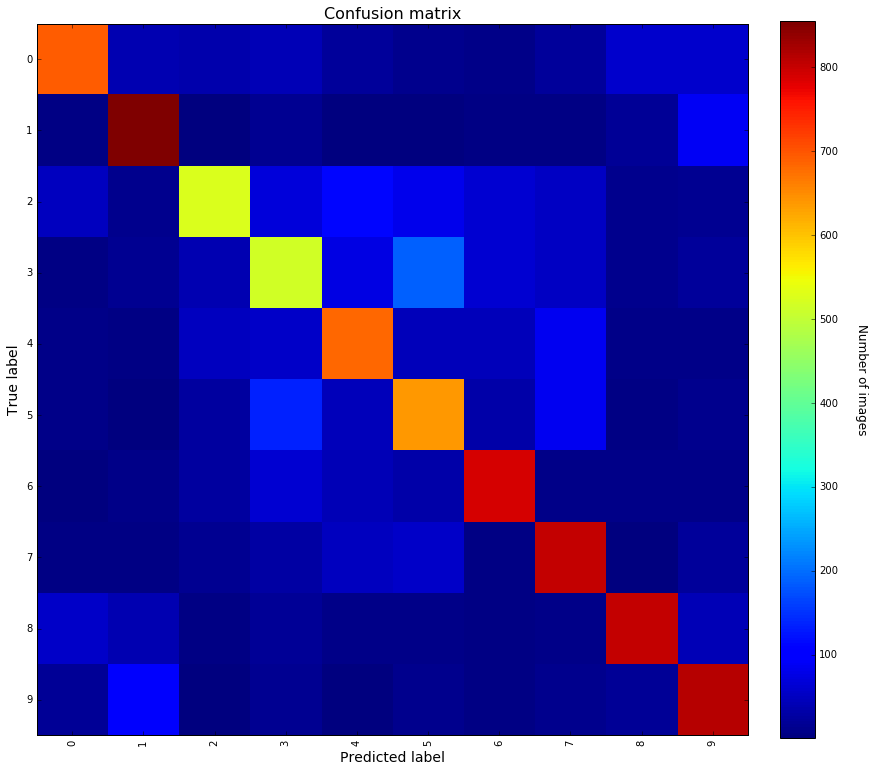

In [18]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array, interpolation='nearest', cmap=plt.cm.jet)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size

print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred)

#### Analyzing the confusion matrix
Knowing the class labels :
0 : airplane 
1 : automobile 
2 : bird 
3 : cat 
4 : deer 
5 : dog 
6 : frog 
7 : horse 
8 : ship 
9 : truck

One can notice that the classes for which the F1-score is below 70% all correspond to animals. 

Some remarkable facts out of the confusion matrix : 
- Trucks and cars are sometimes mixed up
- Birds are the only animals that are sometimes mistakenly classified as planes. The reason behind might be that those two classes are the only ones in which the background is often a blue sky. Hence our model "deduces" from the similar background that the bird picture belongs to the "airplane" class
- Cats are often misclassified as dogs, and the opposite is as well true
- Deers are mainly misclassified as horses


## Conclusion

With minimal efforts, we managed to reach an average F1-score of 71%, which is not that bad for a classification task wtih 10 labels. To improve the performances (the [Kaggle leaderboard](https://www.kaggle.com/c/cifar-10/leaderboard) demonstrates that the mean accuracy can go up to 95%), we could set up more complex model architectures so as to refine the feature extraction. It could also be worth trying some pre-processing on the images, for example finding a way to handle the blue-sky backgrounds that are misleading the classification for planes and brids.